=== ANÁLISIS DEL SISTEMA NU OCTANTIS (hasta 140 años) ===


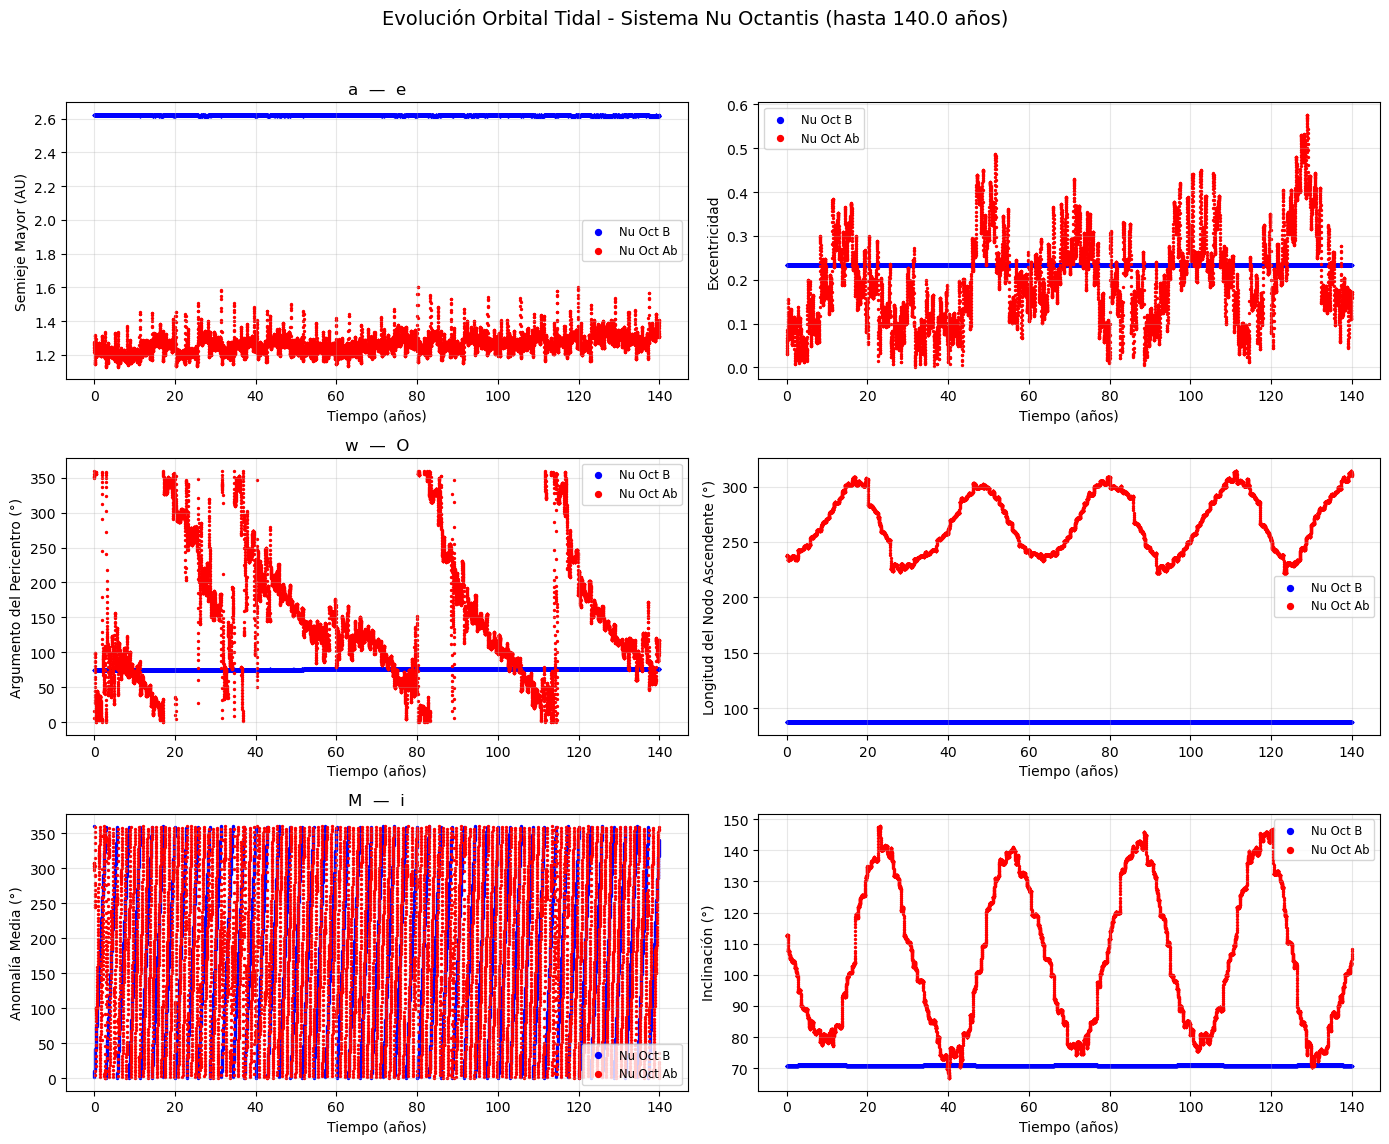


Análisis detallado del Nu Oct B (archivo: planet1.dat)


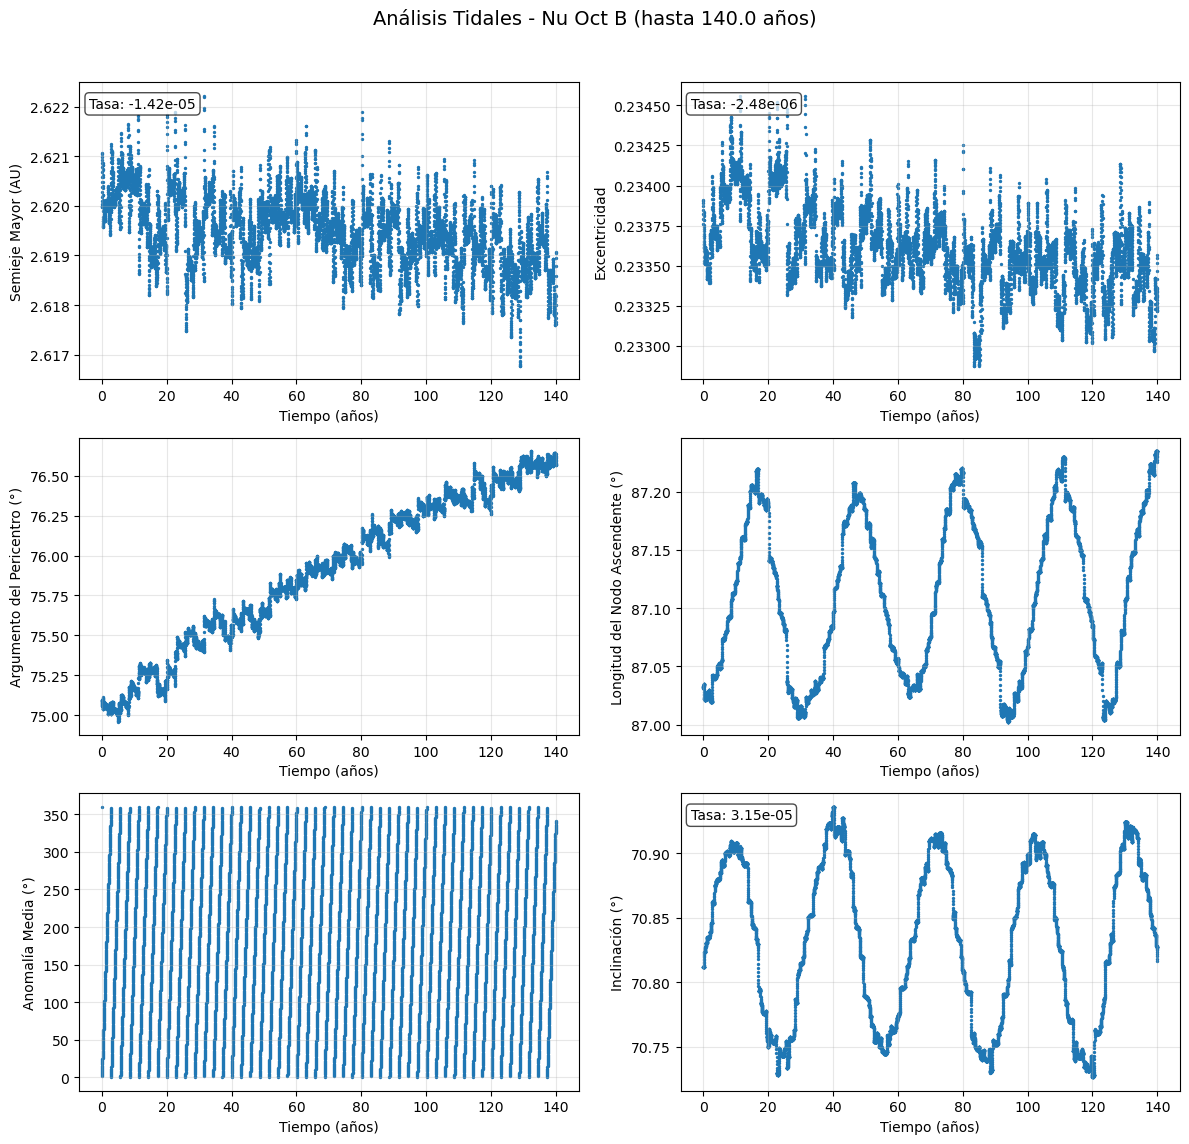

=== ANÁLISIS DE ESCALAS TEMPORALES TIDALES ===
Archivo: planet1.dat
Tiempo de simulación (filtrado): 1.40e+02 días
                     = 3.83e-01 años

CAMBIOS EN ELEMENTOS ORBITALES:
Δa = -0.001992 AU (tasa: -5.20e-03 AU/año)
Δe = -0.000347    (tasa: -9.05e-04 /año)
Δi = 0.004409 °  (tasa: 1.15e-02 °/año)

ESCALA DE CIRCULARIZACIÓN:
τ_circ ≈ 2.59e+02 años (para e → 0)

ESCALA DE MIGRACIÓN:
τ_mig ≈ 5.04e+02 años (cambio significativo en a)
--------------------------------------------------

Análisis detallado del Nu Oct Ab (archivo: planet2.dat)


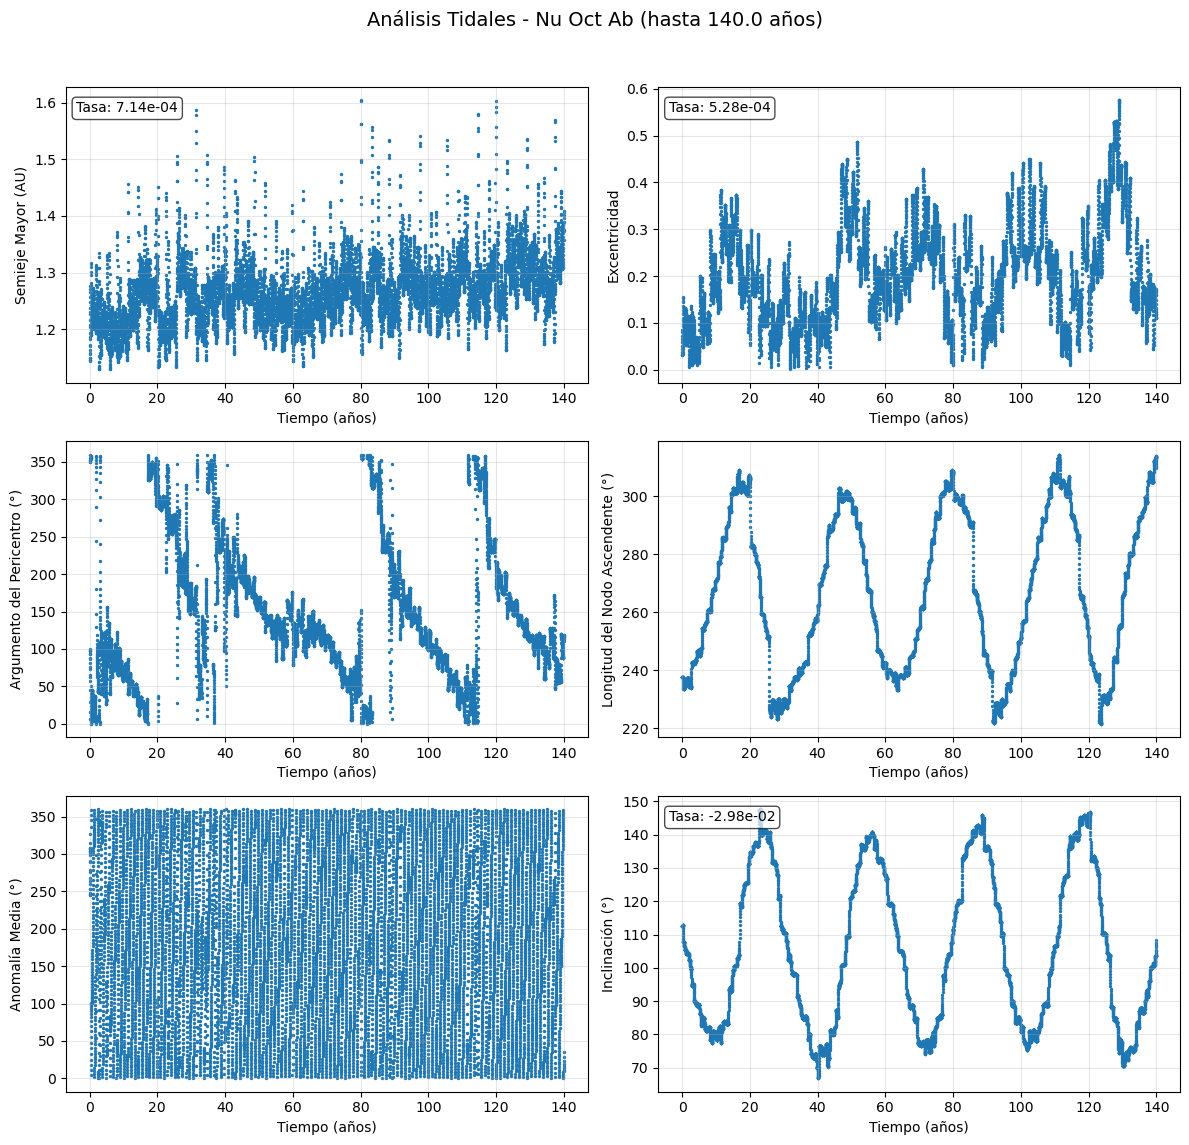

=== ANÁLISIS DE ESCALAS TEMPORALES TIDALES ===
Archivo: planet2.dat
Tiempo de simulación (filtrado): 1.40e+02 días
                     = 3.83e-01 años

CAMBIOS EN ELEMENTOS ORBITALES:
Δa = 0.100012 AU (tasa: 2.61e-01 AU/año)
Δe = 0.073898    (tasa: 1.93e-01 /año)
Δi = -4.171878 °  (tasa: -1.09e+01 °/año)

ESCALA DE CIRCULARIZACIÓN:
τ_circ ≈ 4.46e-01 años (para e → 0)

ESCALA DE MIGRACIÓN:
τ_mig ≈ 4.89e+00 años (cambio significativo en a)
--------------------------------------------------


In [1]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

def read_ncorp_planet_data(planet_file):
    """
    Lee datos de un archivo individual de planeta de NCORP
    
    Parameters:
    -----------
    planet_file : str
        Ruta al archivo planetN.dat
        
    Returns:
    --------
    pd.DataFrame : Datos del planeta con columnas nombradas
    """
    try:
        # Leer el archivo (formato: t, a, e, i, M, w, O, [otros parámetros])
        data = pd.read_csv(planet_file, sep=r'\s+', header=None, comment='#')
        
        # Determinar número de columnas y asignar nombres
        ncols = data.shape[1]
        
        # Columnas básicas según documentación de NCORP
        base_columns = ['t', 'a', 'e', 'i', 'M', 'w', 'O']
        
        # Columnas adicionales posibles según configuración
        additional_columns = ['theta', 'mass', 'radius', 'P_rot_star', 'P_rot_planet', 
                            'P_orbital', 'energy', 'ang_momentum', 'chaos1', 'chaos2', 
                            'chaos3', 'chaos4']
        
        # Asignar columnas según el número disponible
        columns = base_columns + additional_columns[:max(0, ncols-len(base_columns))]
        data.columns = columns[:ncols]
        
        return data
        
    except Exception as e:
        print(f"Error leyendo {planet_file}: {e}")
        return None

def _maybe_deg(series):
    """Si la serie parece estar en radianes (max <= 2π) la convierte a grados."""
    if series is None or len(series) == 0:
        return series
    try:
        if np.abs(series).max() <= 2 * np.pi:
            return np.degrees(series)
    except Exception:
        pass
    return series

# Mapeo de nombres deseado para planetas
_PLANET_NAME_MAP = {
    '1': 'Nu Oct B',
    '2': 'Nu Oct Ab'
}

def _planet_label(planet_num):
    """Devuelve nombre bonito para leyenda/archivos."""
    return _PLANET_NAME_MAP.get(str(planet_num), f'Nu Oct {planet_num}')

def plot_nuoct_system(data_dir='.', output_dir='plots', max_years=140.0, marker_size=2):
    """
    Grafica la evolución orbital del sistema Nu Octantis en pares 3x2:
    (a, e), (w, O), (M, i). Convierte ángulos a grados si parecen estar en radianes.
    Usa nombres personalizados para planeta 1 y 2.
    """
    planet_files = sorted(glob.glob(os.path.join(data_dir, 'planet*.dat')))
    if not planet_files:
        print("No se encontraron archivos planet*.dat en el directorio")
        return None

    planets_data = {}
    for pfile in planet_files:
        planet_num = os.path.basename(pfile).replace('planet', '').replace('.dat', '')
        data = read_ncorp_planet_data(pfile)
        if data is None:
            continue
        t_years = data['t'] / 365.25 if data['t'].max() > 1000 else data['t']
        data = data.copy()
        data['t_years'] = t_years
        data = data[data['t_years'] <= max_years]
        if len(data) > 0:
            planets_data[planet_num] = data

    if not planets_data:
        print(f"No hay datos hasta {max_years} años")
        return None

    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    axs = axs.flatten()
    fig.suptitle(f'Evolución Orbital Tidal - Sistema Nu Octantis (hasta {max_years} años)', fontsize=14)

    # pares: (a,e), (w,O), (M,i)
    pair_configs = [
        ('a', 'Semieje Mayor (AU)'),
        ('e', 'Excentricidad'),
        ('w', 'Argumento del Pericentro (°)'),
        ('O', 'Longitud del Nodo Ascendente (°)'),
        ('M', 'Anomalía Media (°)'),
        ('i', 'Inclinación (°)'),
    ]

    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

    for ax_idx, (param, ylabel) in enumerate(pair_configs):
        ax = axs[ax_idx]
        plotted = False
        for i, (planet_num, data) in enumerate(planets_data.items()):
            if param in data.columns and len(data) > 0:
                series = data[param]
                # convertir ángulos a grados si parecen radianes
                if param in ['w', 'O', 'M', 'i']:
                    series = _maybe_deg(series)
                color = colors[i % len(colors)]
                label = _planet_label(planet_num)
                ax.scatter(data['t_years'], series, color=color, s=marker_size,
                           label=label, rasterized=True)
                plotted = True
        ax.set_xlabel('Tiempo (años)')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)
        if plotted:
            ax.legend(fontsize='small', markerscale=3)
        else:
            ax.text(0.5, 0.5, 'No hay datos', transform=ax.transAxes, ha='center')

        # título por pares (filas)
        if ax_idx % 2 == 0:
            pair_row = ax_idx // 2
            left_param = pair_configs[2*pair_row][0]
            right_param = pair_configs[2*pair_row+1][0]
            ax.set_title(f'{left_param}  —  {right_param}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    os.makedirs(output_dir, exist_ok=True)
    outpath = f'{output_dir}/nuoct_system_evolution_3x2_up_to_{int(max_years)}yr_points.png'
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.show()
    return fig, planets_data

def plot_tidal_effects_detailed(planet_file, planet_name=None, output_dir='plots', max_years=140.0, marker_size=2):
    """
    Análisis detallado de un planeta: muestra (a,e), (w,O), (M,i) en 3x2.
    Si planet_name es None se usa el mapeo por número (Nu Oct B / Nu Oct Ab).
    """
    data = read_ncorp_planet_data(planet_file)
    if data is None:
        return None

    t_years = data['t'] / 365.25 if data['t'].max() > 1000 else data['t']
    data = data.copy()
    data['t_years'] = t_years
    data = data[data['t_years'] <= max_years]

    if len(data) < 2:
        print(f"No hay suficientes datos en {planet_file} hasta {max_years} años")
        return None

    planet_num = os.path.basename(planet_file).replace('planet', '').replace('.dat', '')
    if planet_name is None:
        planet_name = _planet_label(planet_num)

    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    axs = axs.flatten()
    fig.suptitle(f'Análisis Tidales - {planet_name} (hasta {max_years} años)', fontsize=14)

    # mapping: (param, ylabel)
    plot_list = [
        ('a', 'Semieje Mayor (AU)'),
        ('e', 'Excentricidad'),
        ('w', 'Argumento del Pericentro (°)'),
        ('O', 'Longitud del Nodo Ascendente (°)'),
        ('M', 'Anomalía Media (°)'),
        ('i', 'Inclinación (°)')
    ]

    for idx, (param, ylabel) in enumerate(plot_list):
        ax = axs[idx]
        if param in data.columns:
            series = data[param]
            if param in ['w', 'O', 'M', 'i']:
                series = _maybe_deg(series)
            ax.scatter(data['t_years'], series, color='C0', s=marker_size, rasterized=True)
            # tendencias básicas para a, e e i
            if param in ['a', 'e', 'i'] and len(data) > 1:
                rate = (series.iloc[-1] - series.iloc[0]) / (data['t_years'].iloc[-1] - data['t_years'].iloc[0])
                ax.text(0.02, 0.95, f'Tasa: {rate:.2e}', transform=ax.transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7), va='top')
        else:
            ax.text(0.5, 0.5, 'No hay datos', transform=ax.transAxes, ha='center')
        ax.set_xlabel('Tiempo (años)')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    os.makedirs(output_dir, exist_ok=True)
    planet_name_clean = planet_name.replace(' ', '_')
    outpath = f'{output_dir}/tidal_analysis_{planet_name_clean}_3x2_up_to_{int(max_years)}yr_points.png'
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.show()
    return fig, data

def analyze_tidal_timescales(planet_file, max_years=140.0):
    data = read_ncorp_planet_data(planet_file)
    if data is None:
        return None
    t_years = data['t'] / 365.25 if data['t'].max() > 1000 else data['t']
    data = data.copy()
    data['t_years'] = t_years
    data = data[data['t_years'] <= max_years]
    if data is None or len(data) < 2:
        print(f"No hay suficientes datos en {planet_file} hasta {max_years} años")
        return None

    print("=== ANÁLISIS DE ESCALAS TEMPORALES TIDALES ===")
    print(f"Archivo: {planet_file}")
    print(f"Tiempo de simulación (filtrado): {data['t'].iloc[-1] - data['t'].iloc[0]:.2e} días")
    print(f"                     = {(data['t'].iloc[-1] - data['t'].iloc[0])/365.25:.2e} años")

    delta_a = data['a'].iloc[-1] - data['a'].iloc[0]
    delta_e = data['e'].iloc[-1] - data['e'].iloc[0]
    delta_i = data['i'].iloc[-1] - data['i'].iloc[0]
    dt_years = (data['t'].iloc[-1] - data['t'].iloc[0]) / 365.25

    print(f"\nCAMBIOS EN ELEMENTOS ORBITALES:")
    print(f"Δa = {delta_a:.6f} AU (tasa: {delta_a/dt_years:.2e} AU/año)")
    print(f"Δe = {delta_e:.6f}    (tasa: {delta_e/dt_years:.2e} /año)")
    print(f"Δi = {delta_i:.6f} °  (tasa: {delta_i/dt_years:.2e} °/año)")

    if abs(delta_e/dt_years) > 1e-15:
        t_circ = abs(data['e'].iloc[0] / (delta_e/dt_years))
        print(f"\nESCALA DE CIRCULARIZACIÓN:")
        print(f"τ_circ ≈ {t_circ:.2e} años (para e → 0)")

    if abs(delta_a/dt_years) > 1e-15:
        t_mig = abs(data['a'].iloc[0] / (delta_a/dt_years))
        print(f"\nESCALA DE MIGRACIÓN:")
        print(f"τ_mig ≈ {t_mig:.2e} años (cambio significativo en a)")

if __name__ == "__main__":
    print("=== ANÁLISIS DEL SISTEMA NU OCTANTIS (hasta 140 años) ===")
    fig_system, planets_data = plot_nuoct_system(max_years=140.0, marker_size=2)
    planet_files = glob.glob('planet*.dat')
    for pfile in planet_files:
        planet_num = os.path.basename(pfile).replace('planet', '').replace('.dat', '')
        planet_name = _planet_label(planet_num)
        print(f"\nAnálisis detallado del {planet_name} (archivo: {pfile})")
        fig_detail_data = plot_tidal_effects_detailed(pfile, planet_name, max_years=140.0, marker_size=2)
        analyze_tidal_timescales(pfile, max_years=140.0)
        print("-" * 50)
# ...existing code...

In [2]:
import os

In [3]:
# Acá guardo todos los graficos generados como PNG en la carpeta 'plots'

# Crear la carpeta 'plots' si no existe
if not os.path.exists('plots'):
    os.makedirs('plots')

# Guardar la figura del sistema completo
if 'fig_system' in locals():
    fig_system.savefig('plots/nuoct_system_evolution.png', dpi=300, bbox_inches='tight')

# Guardar las figuras detalladas de cada planeta
for planet_num in planets_data.keys():
    fig_name = f'plots/tidal_analysis_Nu_Oct_{planet_num}.png'
    if os.path.exists(fig_name):
        print(f'Figura detallada del Planeta {planet_num} guardada en {fig_name}')
